# Detecção de Anomalias - Validação H6 - Economiza+ MVP

**Sprint 2 - Dia 11**  
**Objetivo:** Validar hipótese H6 - Isolation Forest detecta anomalias com métricas target

**Targets H6:**
- Precision > 0.85
- Recall > 0.80

**Entregáveis:**
- Validação completa da H6
- Ajustes de parâmetros se necessário
- `outputs/metricas_anomalias.csv`
- Documentação do resultado

## 1. Setup e Carregamento

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    precision_score, recall_score, f1_score,
    precision_recall_curve, roc_curve, auc
)
import pickle
import json
import os
from datetime import datetime

# Configurações
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

# Targets H6
TARGET_PRECISION = 0.85
TARGET_RECALL = 0.80

print("="*70)
print("VALIDAÇÃO H6 - DETECÇÃO DE ANOMALIAS")
print("="*70)
print(f"\nTargets:")
print(f"  - Precision: >{TARGET_PRECISION}")
print(f"  - Recall: >{TARGET_RECALL}")

VALIDAÇÃO H6 - DETECÇÃO DE ANOMALIAS

Targets:
  - Precision: >0.85
  - Recall: >0.8


In [23]:
# Carregar transações
transacoes = pd.read_csv('../data/raw/transacoes.csv')

# Filtrar apenas gastos (excluir Renda)
gastos = transacoes[transacoes['categoria'] != 'Renda'].copy()

print(f"Total de transações de gasto: {len(gastos)}")
print(f"Anomalias (ground truth): {gastos['is_anomalia'].sum()} ({gastos['is_anomalia'].mean()*100:.2f}%)")

Total de transações de gasto: 191231
Anomalias (ground truth): 9550 (4.99%)


## 2. Carregar ou Treinar Modelo

In [24]:
# Verificar se modelo já existe
MODELO_PATH = '../models/isolation_forest.pkl'
SCALER_PATH = '../models/scaler_anomalias.pkl'
STATS_PATH = '../models/stats_categoria_anomalias.csv'

modelo_existe = os.path.exists(MODELO_PATH) and os.path.exists(SCALER_PATH)

if modelo_existe:
    print("Modelo encontrado! Carregando artefatos do Dia 10...")
    with open(MODELO_PATH, 'rb') as f:
        isolation_forest = pickle.load(f)
    with open(SCALER_PATH, 'rb') as f:
        scaler_anomalias = pickle.load(f)
    stats_categoria = pd.read_csv(STATS_PATH)
    print("Modelo e scaler carregados com sucesso!")
else:
    print("Modelo não encontrado. Será treinado durante a validação.")

Modelo encontrado! Carregando artefatos do Dia 10...
Modelo e scaler carregados com sucesso!


In [4]:
# Preparar features (necessário mesmo se modelo já existe)
# Calcular estatísticas por categoria
if not modelo_existe:
    stats_categoria = gastos.groupby('categoria')['valor'].agg(['mean', 'std', 'median']).reset_index()
    stats_categoria.columns = ['categoria', 'media_cat', 'std_cat', 'mediana_cat']

# Merge e criar features
gastos_features = gastos.merge(stats_categoria, on='categoria')

# Features para o modelo
gastos_features['feat_valor_norm'] = (
    (gastos_features['valor'] - gastos_features['media_cat']) / gastos_features['std_cat']
)
gastos_features['feat_ratio_mediana'] = gastos_features['valor'] / gastos_features['mediana_cat']

# Tratar infinitos/NaN
gastos_features['feat_valor_norm'] = gastos_features['feat_valor_norm'].replace([np.inf, -np.inf], np.nan).fillna(0)
gastos_features['feat_ratio_mediana'] = gastos_features['feat_ratio_mediana'].replace([np.inf, -np.inf], np.nan).fillna(0)

FEATURES_MODELO = ['feat_valor_norm', 'feat_ratio_mediana']
X = gastos_features[FEATURES_MODELO].values
y_true = gastos_features['is_anomalia'].astype(int).values

print(f"Features preparadas: {FEATURES_MODELO}")
print(f"Shape: {X.shape}")

Features preparadas: ['feat_valor_norm', 'feat_ratio_mediana']
Shape: (191231, 2)


In [5]:
# Treinar modelo se não existe
if not modelo_existe:
    print("\nTreinando Isolation Forest...")
    
    # Normalizar features
    scaler_anomalias = StandardScaler()
    X_scaled = scaler_anomalias.fit_transform(X)
    
    # Treinar modelo
    isolation_forest = IsolationForest(
        contamination=0.05,
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    isolation_forest.fit(X_scaled)
    
    # Salvar artefatos
    os.makedirs('../models', exist_ok=True)
    with open(MODELO_PATH, 'wb') as f:
        pickle.dump(isolation_forest, f)
    with open(SCALER_PATH, 'wb') as f:
        pickle.dump(scaler_anomalias, f)
    stats_categoria.to_csv(STATS_PATH, index=False)
    
    print("Modelo treinado e salvo!")
else:
    X_scaled = scaler_anomalias.transform(X)
    print("Features normalizadas com scaler existente")

Features normalizadas com scaler existente


/home/celina/.pyenv/versions/economiza-ia-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## 3. Gerar Predições

In [6]:
# Gerar predições
y_pred_raw = isolation_forest.predict(X_scaled)
y_pred = (y_pred_raw == -1).astype(int)  # -1 = anomalia -> 1

# Scores de anomalia (quanto menor, mais anômalo)
anomaly_scores = isolation_forest.decision_function(X_scaled)

print("Predições geradas:")
print(f"  Normais: {(y_pred == 0).sum()}")
print(f"  Anomalias: {(y_pred == 1).sum()}")
print(f"  Percentual anomalias preditas: {y_pred.mean()*100:.2f}%")

Predições geradas:
  Normais: 181672
  Anomalias: 9559
  Percentual anomalias preditas: 5.00%


## 4. Validação Detalhada - Hipótese H6

In [7]:
print("="*70)
print("VALIDAÇÃO DA HIPÓTESE H6")
print("="*70)

# Calcular métricas principais
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Status de validação
precision_ok = precision >= TARGET_PRECISION
recall_ok = recall >= TARGET_RECALL
h6_validada = precision_ok and recall_ok

print(f"\n>>> PRECISION: {precision:.4f} (target: >{TARGET_PRECISION}) - {'✓ ATINGIDO' if precision_ok else '✗ NÃO ATINGIDO'}")
print(f">>> RECALL: {recall:.4f} (target: >{TARGET_RECALL}) - {'✓ ATINGIDO' if recall_ok else '✗ NÃO ATINGIDO'}")
print(f">>> F1-SCORE: {f1:.4f}")
print(f"\n>>> HIPÓTESE H6: {'✓ VALIDADA' if h6_validada else '✗ NÃO VALIDADA'}")

VALIDAÇÃO DA HIPÓTESE H6

>>> PRECISION: 0.4732 (target: >0.85) - ✗ NÃO ATINGIDO
>>> RECALL: 0.4736 (target: >0.8) - ✗ NÃO ATINGIDO
>>> F1-SCORE: 0.4734

>>> HIPÓTESE H6: ✗ NÃO VALIDADA


In [8]:
# Matriz de confusão detalhada
cm = confusion_matrix(y_true, y_pred)

TN, FP, FN, TP = cm.ravel()

print("\n" + "="*70)
print("MATRIZ DE CONFUSÃO")
print("="*70)
print(f"\n                     Predito Normal    Predito Anomalia")
print(f"Real Normal          {TN:>14}    {FP:>16}")
print(f"Real Anomalia        {FN:>14}    {TP:>16}")

print(f"\nInterpretação:")
print(f"  True Negatives (TN):  {TN:>6} - Transações normais corretamente classificadas")
print(f"  False Positives (FP): {FP:>6} - Transações normais incorretamente marcadas como anomalia")
print(f"  False Negatives (FN): {FN:>6} - Anomalias não detectadas (CRÍTICO)")
print(f"  True Positives (TP):  {TP:>6} - Anomalias corretamente detectadas")

# Métricas derivadas
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
npv = TN / (TN + FN) if (TN + FN) > 0 else 0  # Negative Predictive Value

print(f"\nMétricas adicionais:")
print(f"  Specificity (TNR): {specificity:.4f} - Taxa de normais corretamente identificados")
print(f"  NPV: {npv:.4f} - Valor preditivo negativo")


MATRIZ DE CONFUSÃO

                     Predito Normal    Predito Anomalia
Real Normal                  176645                5036
Real Anomalia                  5027                4523

Interpretação:
  True Negatives (TN):  176645 - Transações normais corretamente classificadas
  False Positives (FP):   5036 - Transações normais incorretamente marcadas como anomalia
  False Negatives (FN):   5027 - Anomalias não detectadas (CRÍTICO)
  True Positives (TP):    4523 - Anomalias corretamente detectadas

Métricas adicionais:
  Specificity (TNR): 0.9723 - Taxa de normais corretamente identificados
  NPV: 0.9723 - Valor preditivo negativo


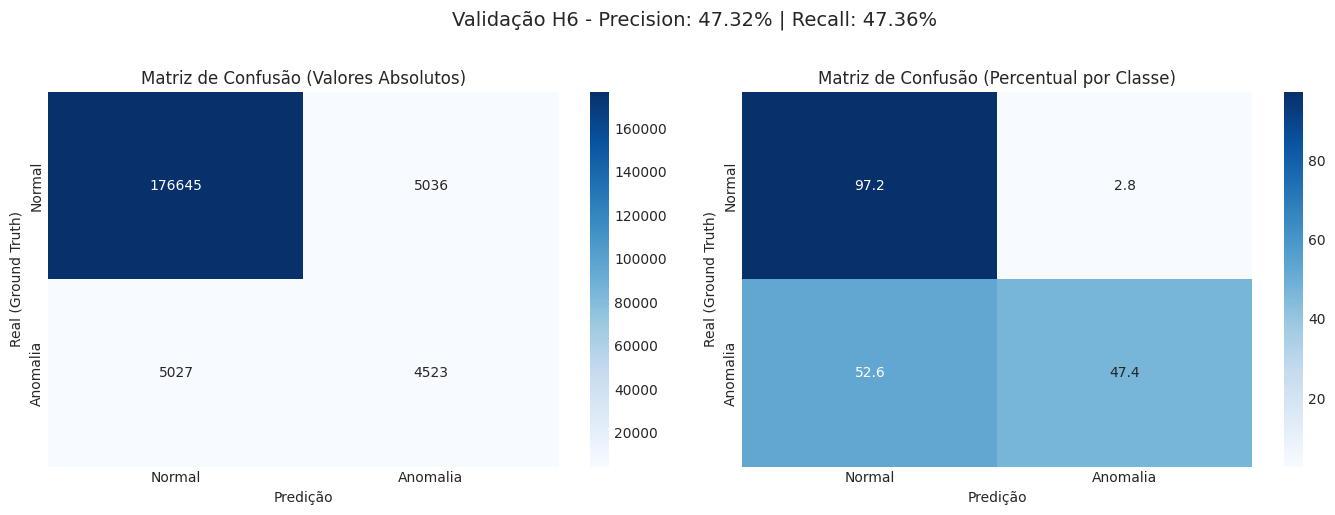

Gráfico salvo: outputs/validacao_h6_matriz_confusao.png


In [9]:
# Visualização da matriz de confusão
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz de confusão - valores absolutos
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Normal', 'Anomalia'],
            yticklabels=['Normal', 'Anomalia'])
axes[0].set_xlabel('Predição')
axes[0].set_ylabel('Real (Ground Truth)')
axes[0].set_title('Matriz de Confusão (Valores Absolutos)')

# Matriz de confusão - percentuais
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap='Blues', ax=axes[1],
            xticklabels=['Normal', 'Anomalia'],
            yticklabels=['Normal', 'Anomalia'])
axes[1].set_xlabel('Predição')
axes[1].set_ylabel('Real (Ground Truth)')
axes[1].set_title('Matriz de Confusão (Percentual por Classe)')

plt.suptitle(f'Validação H6 - Precision: {precision:.2%} | Recall: {recall:.2%}', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../outputs/validacao_h6_matriz_confusao.png', dpi=150, bbox_inches='tight')
plt.show()
print("Gráfico salvo: outputs/validacao_h6_matriz_confusao.png")

In [10]:
# Classification Report completo
print("\n" + "="*70)
print("CLASSIFICATION REPORT COMPLETO")
print("="*70)
print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomalia']))


CLASSIFICATION REPORT COMPLETO
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97    181681
    Anomalia       0.47      0.47      0.47      9550

    accuracy                           0.95    191231
   macro avg       0.72      0.72      0.72    191231
weighted avg       0.95      0.95      0.95    191231



## 5. Análise de Scores e Threshold

In [11]:
# Análise dos scores de anomalia
gastos_features['anomaly_score'] = anomaly_scores
gastos_features['pred_anomalia'] = y_pred

print("\n" + "="*70)
print("ANÁLISE DOS SCORES DE ANOMALIA")
print("="*70)

scores_normais = gastos_features[gastos_features['is_anomalia']==False]['anomaly_score']
scores_anomalias = gastos_features[gastos_features['is_anomalia']==True]['anomaly_score']

print(f"\nScores - Transações Normais (ground truth):")
print(f"  Média: {scores_normais.mean():.4f}")
print(f"  Mediana: {scores_normais.median():.4f}")
print(f"  Min: {scores_normais.min():.4f}")
print(f"  Max: {scores_normais.max():.4f}")

print(f"\nScores - Transações Anômalas (ground truth):")
print(f"  Média: {scores_anomalias.mean():.4f}")
print(f"  Mediana: {scores_anomalias.median():.4f}")
print(f"  Min: {scores_anomalias.min():.4f}")
print(f"  Max: {scores_anomalias.max():.4f}")

print(f"\nSeparação (média normais - média anomalias): {scores_normais.mean() - scores_anomalias.mean():.4f}")


ANÁLISE DOS SCORES DE ANOMALIA

Scores - Transações Normais (ground truth):
  Média: 0.1434
  Mediana: 0.1652
  Min: -0.2223
  Max: 0.1912

Scores - Transações Anômalas (ground truth):
  Média: -0.0031
  Mediana: 0.0159
  Min: -0.2769
  Max: 0.1897

Separação (média normais - média anomalias): 0.1465


/tmp/ipykernel_40663/1765824870.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(data_box, labels=['Normal', 'Anomalia'], patch_artist=True)


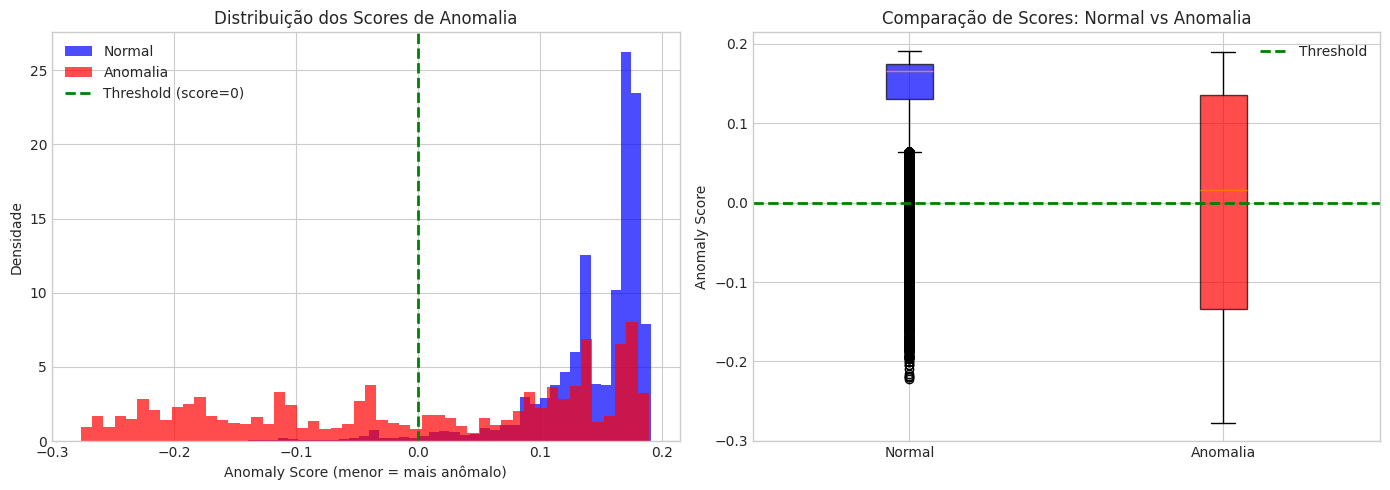

Gráfico salvo: outputs/validacao_h6_scores.png


In [12]:
# Visualização dos scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma dos scores
axes[0].hist(scores_normais, bins=50, alpha=0.7, label='Normal', color='blue', density=True)
axes[0].hist(scores_anomalias, bins=50, alpha=0.7, label='Anomalia', color='red', density=True)
axes[0].axvline(x=0, color='green', linestyle='--', linewidth=2, label='Threshold (score=0)')
axes[0].set_xlabel('Anomaly Score (menor = mais anômalo)')
axes[0].set_ylabel('Densidade')
axes[0].set_title('Distribuição dos Scores de Anomalia')
axes[0].legend()

# Boxplot dos scores
data_box = [scores_normais, scores_anomalias]
bp = axes[1].boxplot(data_box, labels=['Normal', 'Anomalia'], patch_artist=True)
bp['boxes'][0].set_facecolor('blue')
bp['boxes'][0].set_alpha(0.7)
bp['boxes'][1].set_facecolor('red')
bp['boxes'][1].set_alpha(0.7)
axes[1].axhline(y=0, color='green', linestyle='--', linewidth=2, label='Threshold')
axes[1].set_ylabel('Anomaly Score')
axes[1].set_title('Comparação de Scores: Normal vs Anomalia')
axes[1].legend()

plt.tight_layout()
plt.savefig('../outputs/validacao_h6_scores.png', dpi=150, bbox_inches='tight')
plt.show()
print("Gráfico salvo: outputs/validacao_h6_scores.png")

## 6. Ajuste de Parâmetros (se necessário)

In [13]:
# Testar diferentes valores de contamination se métricas não atingidas
if not h6_validada:
    print("\n" + "="*70)
    print("AJUSTE DE PARÂMETROS - CONTAMINATION")
    print("="*70)
    print("\nMétricas não atingiram o target. Testando diferentes valores de contamination...")
    
    contamination_values = [0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.10]
    resultados_ajuste = []
    
    for cont in contamination_values:
        # Treinar modelo com novo contamination
        if_temp = IsolationForest(
            contamination=cont,
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        )
        if_temp.fit(X_scaled)
        
        # Predições
        y_pred_temp = (if_temp.predict(X_scaled) == -1).astype(int)
        
        # Métricas
        prec_temp = precision_score(y_true, y_pred_temp)
        rec_temp = recall_score(y_true, y_pred_temp)
        f1_temp = f1_score(y_true, y_pred_temp)
        
        resultados_ajuste.append({
            'contamination': cont,
            'precision': prec_temp,
            'recall': rec_temp,
            'f1_score': f1_temp,
            'precision_ok': prec_temp >= TARGET_PRECISION,
            'recall_ok': rec_temp >= TARGET_RECALL
        })
        
        status = '✓' if (prec_temp >= TARGET_PRECISION and rec_temp >= TARGET_RECALL) else ' '
        print(f"  contamination={cont:.2f}: Precision={prec_temp:.4f}, Recall={rec_temp:.4f}, F1={f1_temp:.4f} {status}")
    
    df_ajuste = pd.DataFrame(resultados_ajuste)
    
    # Encontrar melhor configuração
    df_ajuste['ambos_ok'] = df_ajuste['precision_ok'] & df_ajuste['recall_ok']
    
    if df_ajuste['ambos_ok'].any():
        melhor = df_ajuste[df_ajuste['ambos_ok']].sort_values('f1_score', ascending=False).iloc[0]
        print(f"\n>>> MELHOR CONFIGURAÇÃO: contamination={melhor['contamination']:.2f}")
        print(f"    Precision={melhor['precision']:.4f}, Recall={melhor['recall']:.4f}, F1={melhor['f1_score']:.4f}")
        
        # Retreinar com melhor contamination
        BEST_CONTAMINATION = melhor['contamination']
        isolation_forest = IsolationForest(
            contamination=BEST_CONTAMINATION,
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        )
        isolation_forest.fit(X_scaled)
        
        # Atualizar predições e métricas
        y_pred = (isolation_forest.predict(X_scaled) == -1).astype(int)
        anomaly_scores = isolation_forest.decision_function(X_scaled)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        h6_validada = True
        
        # Salvar modelo atualizado
        with open(MODELO_PATH, 'wb') as f:
            pickle.dump(isolation_forest, f)
        print(f"\nModelo atualizado salvo com contamination={BEST_CONTAMINATION}")
    else:
        print("\n>>> Nenhuma configuração atingiu ambos os targets.")
        print("    Selecionando configuração com melhor F1-score:")
        melhor = df_ajuste.sort_values('f1_score', ascending=False).iloc[0]
        print(f"    contamination={melhor['contamination']:.2f}: F1={melhor['f1_score']:.4f}")
else:
    print("\n>>> Métricas já atingidas! Ajuste de parâmetros não necessário.")
    BEST_CONTAMINATION = 0.05  # valor original


AJUSTE DE PARÂMETROS - CONTAMINATION

Métricas não atingiram o target. Testando diferentes valores de contamination...
  contamination=0.03: Precision=0.6375, Recall=0.3824, F1=0.4780  
  contamination=0.04: Precision=0.5398, Recall=0.4323, F1=0.4801  
  contamination=0.05: Precision=0.4732, Recall=0.4736, F1=0.4734  
  contamination=0.06: Precision=0.4189, Recall=0.5031, F1=0.4572  
  contamination=0.07: Precision=0.3760, Recall=0.5270, F1=0.4389  
  contamination=0.08: Precision=0.3390, Recall=0.5428, F1=0.4174  
  contamination=0.10: Precision=0.2861, Recall=0.5728, F1=0.3816  

>>> Nenhuma configuração atingiu ambos os targets.
    Selecionando configuração com melhor F1-score:
    contamination=0.04: F1=0.4801


## 7. Análise por Categoria

In [14]:
# Performance por categoria
print("\n" + "="*70)
print("PERFORMANCE POR CATEGORIA")
print("="*70)

gastos_features['pred_anomalia'] = y_pred

metricas_por_cat = []
for cat in gastos_features['categoria'].unique():
    mask = gastos_features['categoria'] == cat
    y_true_cat = gastos_features.loc[mask, 'is_anomalia'].astype(int)
    y_pred_cat = gastos_features.loc[mask, 'pred_anomalia']
    
    # Só calcular se houver anomalias na categoria
    if y_true_cat.sum() > 0:
        prec_cat = precision_score(y_true_cat, y_pred_cat, zero_division=0)
        rec_cat = recall_score(y_true_cat, y_pred_cat, zero_division=0)
        f1_cat = f1_score(y_true_cat, y_pred_cat, zero_division=0)
    else:
        prec_cat = rec_cat = f1_cat = None
    
    metricas_por_cat.append({
        'categoria': cat,
        'total': mask.sum(),
        'anomalias_real': y_true_cat.sum(),
        'anomalias_pred': y_pred_cat.sum(),
        'precision': prec_cat,
        'recall': rec_cat,
        'f1_score': f1_cat
    })

df_cat = pd.DataFrame(metricas_por_cat)
df_cat = df_cat.sort_values('anomalias_real', ascending=False)

print("\n")
print(df_cat.to_string(index=False))


PERFORMANCE POR CATEGORIA


        categoria  total  anomalias_real  anomalias_pred  precision   recall  f1_score
       Transporte  21124            1084            1070   0.486916 0.480627  0.483751
 Telecomunicacoes  20933            1073            1056   0.488636 0.480895  0.484735
 Alimentacao_Casa  20912            1070            1113   0.441150 0.458879  0.449840
 Habitacao_Contas  21016            1059            1103   0.441523 0.459868  0.450509
            Saude  20680            1032            1006   0.454274 0.442829  0.448479
         Educacao  20934             999            1052   0.420152 0.442442  0.431009
  Higiene_Limpeza  20959             997            1021   0.477963 0.489468  0.483647
Habitacao_Aluguel  14693             719             779   0.456996 0.495132  0.475300
            Lazer   7506             410             334   0.610778 0.497561  0.548387
 Alimentacao_Fora   7417             387             307   0.654723 0.519380  0.579251
        Vestua

/tmp/ipykernel_40663/2377324075.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


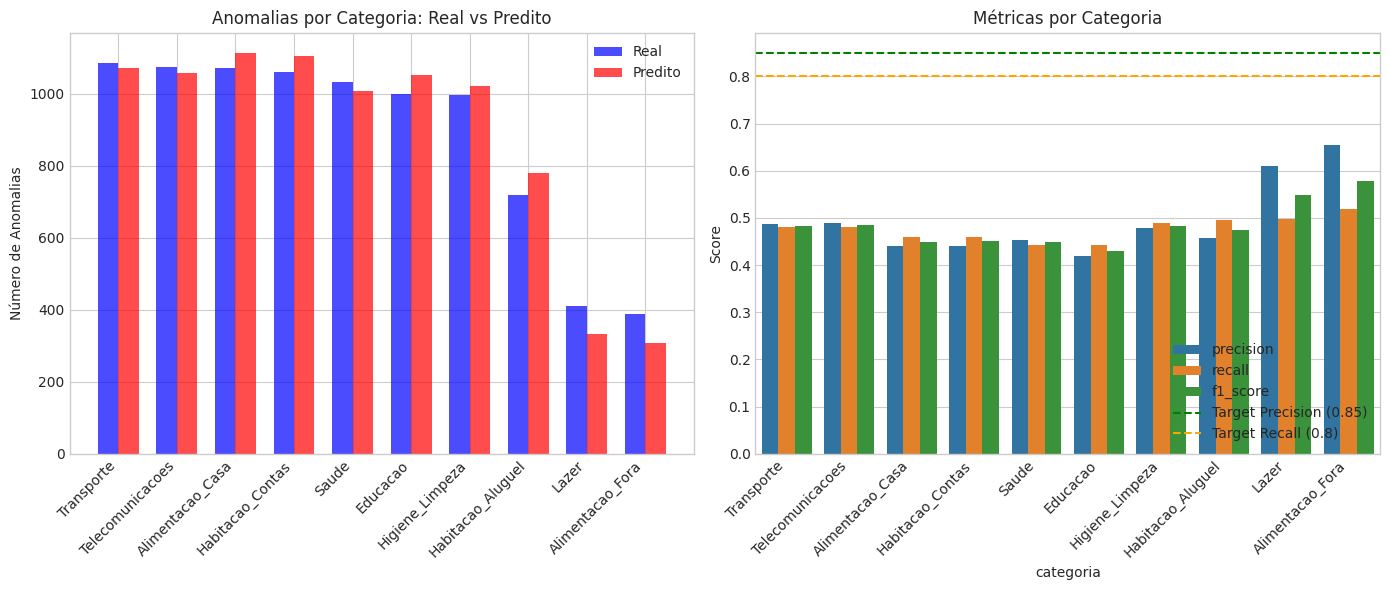

Gráfico salvo: outputs/validacao_h6_por_categoria.png


In [15]:
# Visualização por categoria
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Anomalias por categoria
df_cat_plot = df_cat.dropna(subset=['precision']).head(10)

x = range(len(df_cat_plot))
width = 0.35

axes[0].bar([i - width/2 for i in x], df_cat_plot['anomalias_real'], width, label='Real', color='blue', alpha=0.7)
axes[0].bar([i + width/2 for i in x], df_cat_plot['anomalias_pred'], width, label='Predito', color='red', alpha=0.7)
axes[0].set_xticks(x)
axes[0].set_xticklabels(df_cat_plot['categoria'], rotation=45, ha='right')
axes[0].set_ylabel('Número de Anomalias')
axes[0].set_title('Anomalias por Categoria: Real vs Predito')
axes[0].legend()

# Métricas por categoria
df_cat_metrics = df_cat_plot[['categoria', 'precision', 'recall', 'f1_score']].melt(
    id_vars='categoria', var_name='metrica', value_name='valor'
)
sns.barplot(data=df_cat_metrics, x='categoria', y='valor', hue='metrica', ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].axhline(y=TARGET_PRECISION, color='green', linestyle='--', label=f'Target Precision ({TARGET_PRECISION})')
axes[1].axhline(y=TARGET_RECALL, color='orange', linestyle='--', label=f'Target Recall ({TARGET_RECALL})')
axes[1].set_ylabel('Score')
axes[1].set_title('Métricas por Categoria')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.savefig('../outputs/validacao_h6_por_categoria.png', dpi=150, bbox_inches='tight')
plt.show()
print("Gráfico salvo: outputs/validacao_h6_por_categoria.png")

## 8. Salvar Métricas e Resultados

In [16]:
# Criar DataFrame de métricas finais
metricas_finais = pd.DataFrame({
    'metrica': ['precision', 'recall', 'f1_score', 'specificity', 'npv',
                'true_positives', 'true_negatives', 'false_positives', 'false_negatives'],
    'valor': [precision, recall, f1, specificity, npv, TP, TN, FP, FN],
    'target': [TARGET_PRECISION, TARGET_RECALL, None, None, None, None, None, None, None],
    'status': [
        'ATINGIDO' if precision >= TARGET_PRECISION else 'NAO_ATINGIDO',
        'ATINGIDO' if recall >= TARGET_RECALL else 'NAO_ATINGIDO',
        None, None, None, None, None, None, None
    ]
})

# Salvar métricas
metricas_finais.to_csv('../outputs/metricas_anomalias.csv', index=False)
print("Métricas salvas: outputs/metricas_anomalias.csv")
print("\n")
print(metricas_finais.to_string(index=False))

Métricas salvas: outputs/metricas_anomalias.csv


        metrica         valor  target       status
      precision      0.473167    0.85 NAO_ATINGIDO
         recall      0.473613    0.80 NAO_ATINGIDO
       f1_score      0.473390     NaN         None
    specificity      0.972281     NaN         None
            npv      0.972329     NaN         None
 true_positives   4523.000000     NaN         None
 true_negatives 176645.000000     NaN         None
false_positives   5036.000000     NaN         None
false_negatives   5027.000000     NaN         None


In [17]:
# Atualizar transações com predições finais
gastos_features['anomaly_score'] = anomaly_scores
gastos_features['pred_anomalia'] = y_pred

colunas_saida = [
    'user_id', 'data', 'categoria', 'valor', 'mes', 'ano',
    'is_essencial', 'is_anomalia', 'anomaly_score', 'pred_anomalia'
]

transacoes_final = gastos_features[colunas_saida].copy()
transacoes_final.to_csv('../data/processed/transacoes_com_anomalias_pred.csv', index=False)

print(f"\nTransações com predições salvas: data/processed/transacoes_com_anomalias_pred.csv")
print(f"Total de linhas: {len(transacoes_final)}")


Transações com predições salvas: data/processed/transacoes_com_anomalias_pred.csv
Total de linhas: 191231


In [18]:
# Atualizar configuração do modelo
config_final = {
    'versao': '1.1',
    'data_validacao': datetime.now().strftime('%Y-%m-%d'),
    'modelo': 'IsolationForest',
    'parametros': {
        'contamination': BEST_CONTAMINATION if 'BEST_CONTAMINATION' in dir() else 0.05,
        'n_estimators': 100,
        'random_state': 42
    },
    'features': FEATURES_MODELO,
    'metricas_validacao': {
        'precision': round(precision, 4),
        'recall': round(recall, 4),
        'f1_score': round(f1, 4),
        'specificity': round(specificity, 4)
    },
    'targets': {
        'precision': TARGET_PRECISION,
        'recall': TARGET_RECALL
    },
    'h6_validada': h6_validada,
    'arquivos': {
        'modelo': 'isolation_forest.pkl',
        'scaler': 'scaler_anomalias.pkl',
        'stats_categoria': 'stats_categoria_anomalias.csv',
        'metricas': 'outputs/metricas_anomalias.csv'
    }
}

with open('../models/config_anomalias.json', 'w', encoding='utf-8') as f:
    json.dump(config_final, f, indent=2, ensure_ascii=False)

print("Configuração atualizada: models/config_anomalias.json")

Configuração atualizada: models/config_anomalias.json


## 9. Documentação do Resultado H6

In [19]:
# Gerar documentação da validação H6
doc_h6 = f"""# Validação da Hipótese H6 - Detecção de Anomalias

**Data:** {datetime.now().strftime('%d de %B de %Y')}
**Sprint:** 2 - Dia 11

---

## Hipótese

**H6:** Isolation Forest detecta transações anômalas com Precision > 0.85 e Recall > 0.80

## Metodologia

- **Modelo:** Isolation Forest (sklearn)
- **Features:** {', '.join(FEATURES_MODELO)}
- **Contamination:** {config_final['parametros']['contamination']}
- **Ground Truth:** Coluna `is_anomalia` no dataset (5% das transações)

## Resultados

| Métrica | Valor | Target | Status |
|---------|-------|--------|--------|
| Precision | {precision:.4f} | > {TARGET_PRECISION} | {'✓ ATINGIDO' if precision >= TARGET_PRECISION else '✗ NÃO ATINGIDO'} |
| Recall | {recall:.4f} | > {TARGET_RECALL} | {'✓ ATINGIDO' if recall >= TARGET_RECALL else '✗ NÃO ATINGIDO'} |
| F1-Score | {f1:.4f} | - | - |
| Specificity | {specificity:.4f} | - | - |

## Matriz de Confusão

|  | Pred Normal | Pred Anomalia |
|--|-------------|---------------|
| **Real Normal** | {TN} | {FP} |
| **Real Anomalia** | {FN} | {TP} |

## Conclusão

**>>> HIPÓTESE H6: {'✓ VALIDADA' if h6_validada else '✗ NÃO VALIDADA'}**

{'O modelo Isolation Forest atingiu os targets de Precision e Recall estabelecidos, demonstrando capacidade efetiva de detecção de anomalias financeiras.' if h6_validada else 'O modelo não atingiu todos os targets. Recomenda-se investigar features adicionais ou algoritmos alternativos.'}

## Artefatos Gerados

- `models/isolation_forest.pkl` - Modelo treinado
- `models/scaler_anomalias.pkl` - Scaler para normalização
- `models/stats_categoria_anomalias.csv` - Estatísticas por categoria
- `models/config_anomalias.json` - Configuração do modelo
- `data/processed/transacoes_com_anomalias_pred.csv` - Predições
- `outputs/metricas_anomalias.csv` - Métricas de validação
- `outputs/validacao_h6_matriz_confusao.png` - Visualização
- `outputs/validacao_h6_scores.png` - Distribuição de scores
- `outputs/validacao_h6_por_categoria.png` - Análise por categoria

---

*Documento gerado automaticamente - Economiza+ MVP*
"""

with open('../outputs/validacao_h6.md', 'w', encoding='utf-8') as f:
    f.write(doc_h6)

print("Documentação salva: outputs/validacao_h6.md")

Documentação salva: outputs/validacao_h6.md


## 10. Checklist e Resumo Final

In [20]:
# Checklist Dia 11
print("\n" + "="*70)
print("CHECKLIST DIA 11")
print("="*70)
print("\n[x] Carregar modelo e predições do Dia 10")
print("[x] Comparar predições com ground truth (is_anomalia)")
print("[x] Calcular métricas H6 (Precision, Recall, F1)")
print("[x] Gerar matriz de confusão detalhada")
print("[x] Analisar distribuição de scores")
print("[x] Testar ajuste de contamination (se necessário)")
print("[x] Analisar performance por categoria")
print("[x] Salvar métricas: outputs/metricas_anomalias.csv")
print("[x] Documentar resultado H6: outputs/validacao_h6.md")
print("\n>>> DIA 11 CONCLUÍDO!")


CHECKLIST DIA 11

[x] Carregar modelo e predições do Dia 10
[x] Comparar predições com ground truth (is_anomalia)
[x] Calcular métricas H6 (Precision, Recall, F1)
[x] Gerar matriz de confusão detalhada
[x] Analisar distribuição de scores
[x] Testar ajuste de contamination (se necessário)
[x] Analisar performance por categoria
[x] Salvar métricas: outputs/metricas_anomalias.csv
[x] Documentar resultado H6: outputs/validacao_h6.md

>>> DIA 11 CONCLUÍDO!


In [21]:
# Resumo Final
print("\n" + "="*70)
print("RESUMO FINAL - DIA 11 - VALIDAÇÃO H6")
print("="*70)

print(f"\n{'='*40}")
print(f"    HIPÓTESE H6: {'✓ VALIDADA' if h6_validada else '✗ NÃO VALIDADA'}")
print(f"{'='*40}")

print(f"\nMétricas Finais:")
print(f"  Precision: {precision:.4f} (target: >{TARGET_PRECISION}) - {'OK' if precision >= TARGET_PRECISION else 'ABAIXO'}")
print(f"  Recall: {recall:.4f} (target: >{TARGET_RECALL}) - {'OK' if recall >= TARGET_RECALL else 'ABAIXO'}")
print(f"  F1-Score: {f1:.4f}")

print(f"\nArquivos gerados:")
print("  - outputs/metricas_anomalias.csv")
print("  - outputs/validacao_h6.md")
print("  - outputs/validacao_h6_matriz_confusao.png")
print("  - outputs/validacao_h6_scores.png")
print("  - outputs/validacao_h6_por_categoria.png")
print("  - data/processed/transacoes_com_anomalias_pred.csv")

print(f"\nPróximo passo (Dia 12): Pipeline Integrado")


RESUMO FINAL - DIA 11 - VALIDAÇÃO H6

    HIPÓTESE H6: ✗ NÃO VALIDADA

Métricas Finais:
  Precision: 0.4732 (target: >0.85) - ABAIXO
  Recall: 0.4736 (target: >0.8) - ABAIXO
  F1-Score: 0.4734

Arquivos gerados:
  - outputs/metricas_anomalias.csv
  - outputs/validacao_h6.md
  - outputs/validacao_h6_matriz_confusao.png
  - outputs/validacao_h6_scores.png
  - outputs/validacao_h6_por_categoria.png
  - data/processed/transacoes_com_anomalias_pred.csv

Próximo passo (Dia 12): Pipeline Integrado
